In [1]:
import sys
sys.path.append("../")
import numpy as np
import phate
import graphtools as gt
import numpy as np
import pygsp
from src.mds import embed_MDS
import scprep
from scipy.spatial.distance import jensenshannon
from src.embedding import EmbJSD, Embheatgeo, EmbHeatPHATE, EmbCTD, EmbGraphMMD, EmbDer, CraneEmb, new_heatgeo
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.cheb import expm_multiply

/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-06 20:07:36.053600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 20:07:37.591388: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 20:07:37.658193: W tensorflow/compiler/xla/str

In [2]:
data, labels = phate.tree.gen_dla(n_branch=5, branch_length=500, n_dim=10, sigma=1)
knn=5
anisotropy=0
decay=40
tau=20

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(


Optimal tau:  [22.26666667]
Using s_gd2 for MDS. None


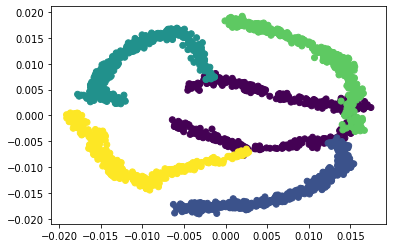

In [6]:
emb_op = new_heatgeo(knn=5,tau="auto", harnack_regul=0.5)
emb = emb_op.fit_transform(data)
plt.scatter(emb[:,0], emb[:,1], c=labels)

/home/mila/g/guillaume.huguet/.local/lib/python3.10/site-packages/graphtools/base.py:165: RuntimeWarning: Cannot perform PCA to 40 dimensions on data with min(n_samples, n_features) = 10
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/metric_emb/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/network/scratch/g/guillaume.huguet/projects/metric_embeddings/src/graph.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X)


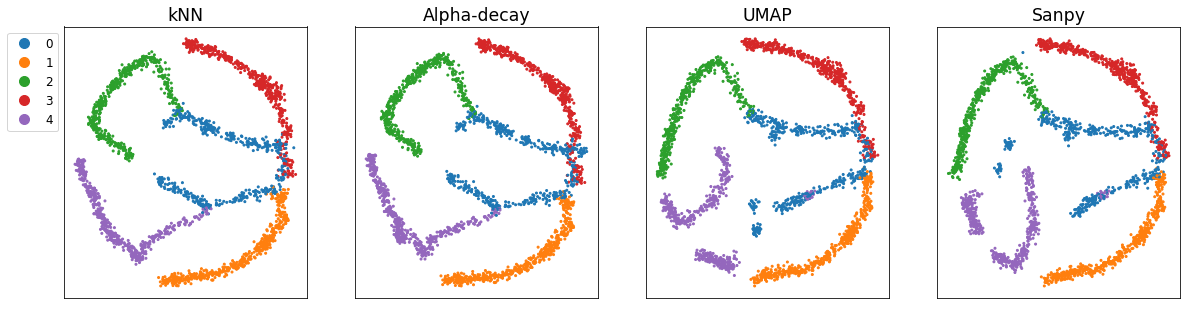

In [23]:
# Figure of embeddings from new_heatgeo depending on the choice of graph  "knn" "alpha" "umap" "scanpy"
graph_types = "knn alpha umap scanpy".split()
names_plot = ["kNN", "Alpha-decay", "UMAP", "Sanpy"] 
fig, axes = plt.subplots(1, len(graph_types), figsize=(len(graph_types)*5, 5))
for i, graph_type in enumerate(graph_types):
    legend = True if i == 0 else False 
    emb = new_heatgeo(graph_type=graph_type, knn=knn, anisotropy=anisotropy, decay=decay, tau=tau).fit_transform(data)
    scprep.plot.scatter2d(emb, c=labels, ax=axes[i], title=names_plot[i], ticks=False,legend=legend, legend_anchor=(0, 1))
fig.savefig("tree_heat_geo_graphs.png", dpi=300)

In [21]:
phate_heat = EmbMultiheatgeo(knn=knn)
emb_heat = phate_heat.fit_transform(data,tau_min=0.5,tau_max=40,lap="norm")
phate_heat = EmbMultiheatgeo(knn=knn)
emb_comb = phate_heat.fit_transform(data,tau_min=0.5,tau_max=40,lap="comb")
fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.scatterplot(emb_comb[:,0],emb_comb[:,1], ax=axes[0], c=labels).set(title="Multi Heat comb")
sns.scatterplot(emb_heat[:,0],emb_heat[:,1], ax=axes[1], c=labels).set(title="Multi Heat norm")

NameError: name 'EmbMultiheatgeo' is not defined

In [12]:
phate_heat = EmbHeatPHATE(knn=knn)
phate = phate.PHATE(knn=knn, t=tau, verbose=False)
emb_heat = phate_heat.fit_transform(data,tau=tau)
emb_phate = phate.fit_transform(data)

/home/mila/g/guillaume.huguet/.conda/envs/ManifoldOT/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mila/g/guillaume.huguet/.conda/envs/ManifoldOT/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Heat-Geo')]

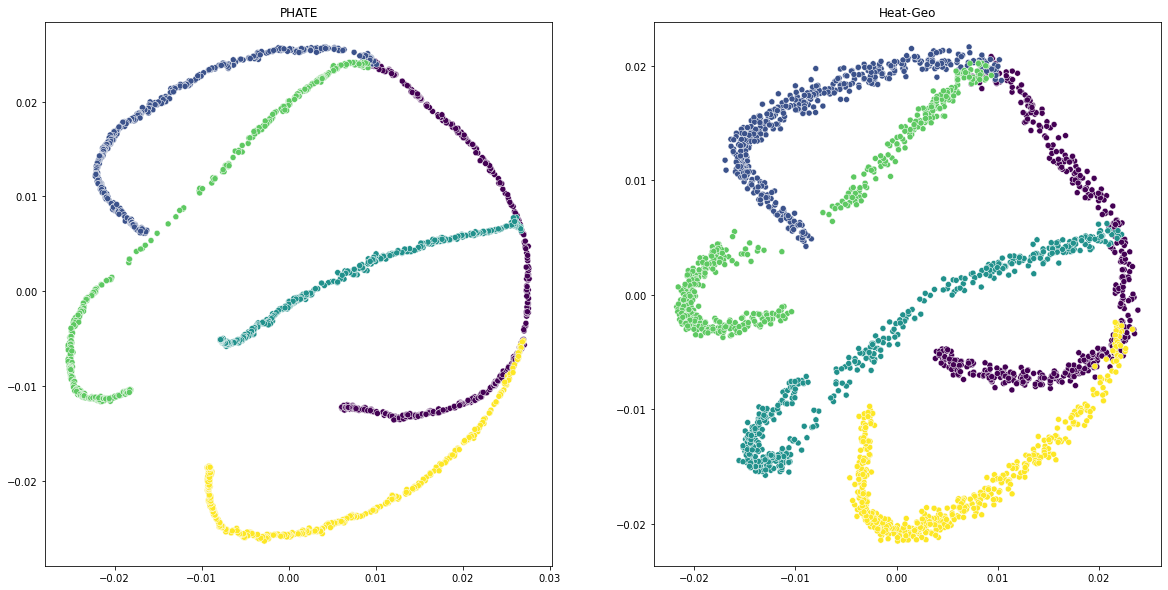

In [17]:
fig, axes = plt.subplots(1,2,figsize=(20,10))
sns.scatterplot(emb_phate[:,0],emb_phate[:,1], ax=axes[0], c=labels).set(title="PHATE")
sns.scatterplot(emb_heat[:,0],emb_heat[:,1], ax=axes[1], c=labels).set(title="Heat-Geo")

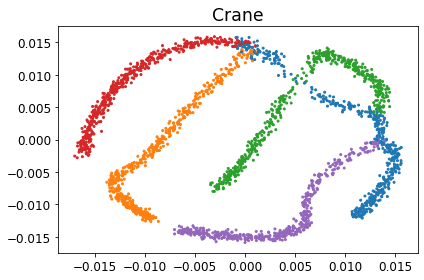

In [6]:
emb_crane = CraneEmb(knn=knn)
emb_crane.scatterplot(data,labels,title="Crane", t=0.05, K=3)

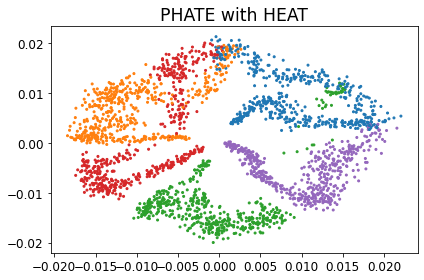

In [3]:
emb_phate_heat = EmbHeatPHATE(knn=knn)
emb_phate_heat.scatterplot(data,labels,title="PHATE with HEAT", tau=0.5)

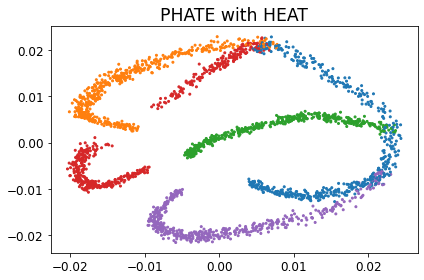

In [4]:
emb_phate_heat = EmbHeatPHATE(knn=knn)
emb_phate_heat.scatterplot(data,labels,title="PHATE with HEAT", tau=10)

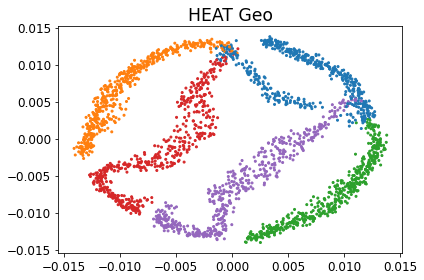

In [5]:
emb_op = Embheatgeo(knn=knn)
emb_op.scatterplot(data,labels,title="HEAT Geo", tau=0.5)

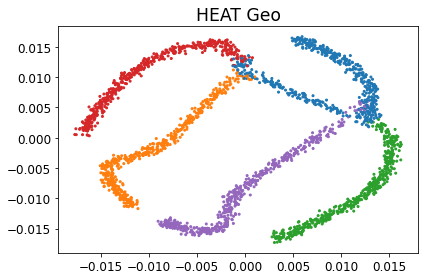

In [7]:
emb_op = Embheatgeo(knn=knn)
emb_op.scatterplot(data,labels,title="HEAT Geo", tau=10)

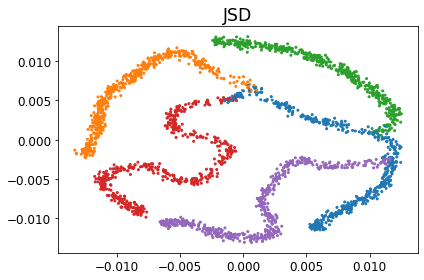

In [8]:
emb_op = EmbJSD(knn=knn)
emb_op.scatterplot(data,labels,title="JSD", tau=10)

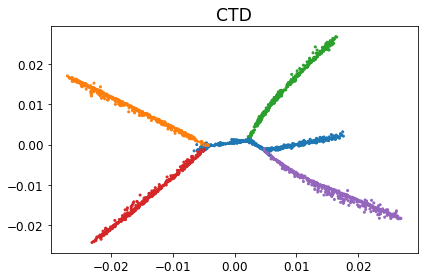

In [5]:
emb_op = EmbCTD(knn=knn)
emb_op.scatterplot(data,labels,title="CTD")

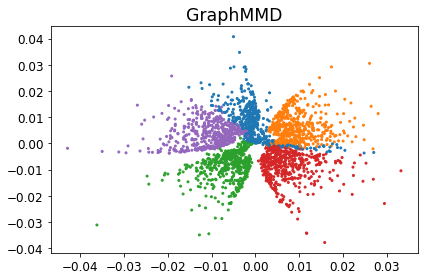

In [6]:
emb_op = EmbGraphMMD(knn=knn)
emb_op.scatterplot(data,labels,title="GraphMMD")

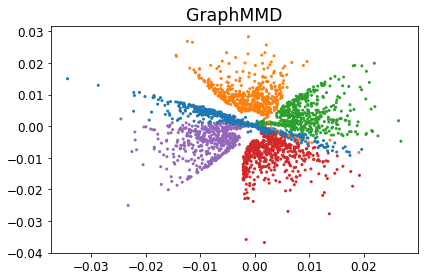

In [7]:
emb_op = EmbGraphMMD(knn=knn)
emb_op.scatterplot(data,labels,title="GraphMMD", T=10)

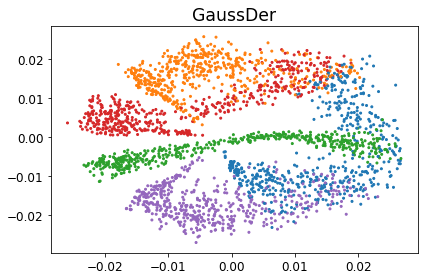

In [5]:
emb_op = EmbDer(knn=knn)
emb_op.scatterplot(data,labels,title="GaussDer", epsilon=1000)